In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import PIL
from PIL import Image
import random
import sklearn
import sys
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from collections import Counter
from keras import regularizers
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm
from tqdm.notebook import tqdm
from tqdm.version import __version__ as tqdm__version__


In [2]:
folder_path = "C:/Users/DOCTOR PC/Documents/AI/emotion/images"
train_dir = folder_path + '/train/'
val_dir = folder_path + '/validation/'

In [3]:
emotions = ['happy', 'angry', 'sad', 'surprise', 'neutral', 'fear', 'disgust']

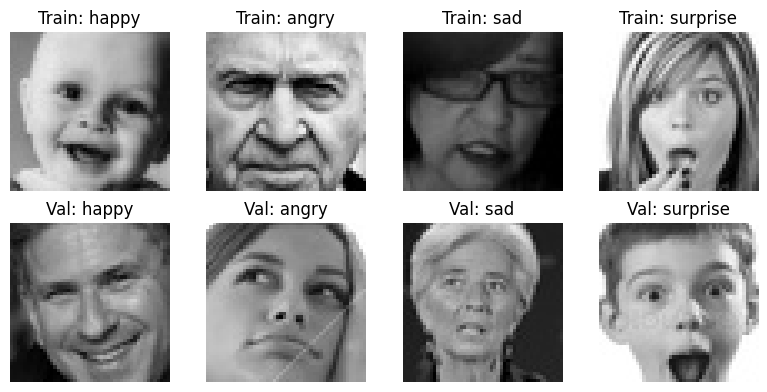

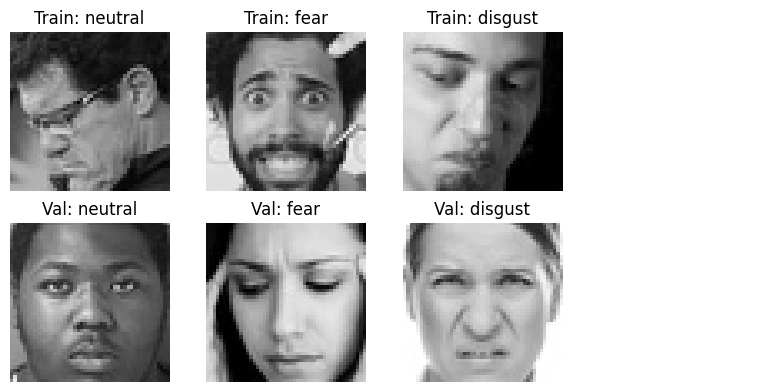

In [4]:
picture_size = 48

for i in range(0, len(emotions), 4):
    fig, axs = plt.subplots(2, 4, figsize=(8, 4))  # 2 rows, 4 columns (train | val for each emotion)
    axs = axs.flatten()
    for j, emotion in enumerate(emotions[i:i+4]):
        # Training image
        train_files = os.listdir(os.path.join(folder_path, "train", emotion))
        random.shuffle(train_files)
        train_img_path = os.path.join(folder_path, "train", emotion, train_files[0])
        train_img = load_img(train_img_path, target_size=(picture_size, picture_size))
        axs[j].imshow(train_img)
        axs[j].set_title(f"Train: {emotion}")
        axs[j].axis('off')
        
        # Validation image
        val_files = os.listdir(os.path.join(folder_path, "validation", emotion))
        random.shuffle(val_files)
        val_img_path = os.path.join(folder_path, "validation", emotion, val_files[0])
        val_img = load_img(val_img_path, target_size=(picture_size, picture_size))
        axs[j+4].imshow(val_img)
        axs[j+4].set_title(f"Val: {emotion}")
        axs[j+4].axis('off')
        
    # Hide unused subplots if emotions are not a multiple of 4
    for k in range(j+1, 4):
        axs[k].axis('off')
        axs[k+4].axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
#use this one , looks more professional

class_directories = os.listdir(train_dir)
class_distributions_dict = {}

for subdirectory in class_directories:
    dir = os.path.join(train_dir, subdirectory)
    files = os.listdir(dir)  # Use 'files' to store the list of files
    num_files = len(files)  # Get the number of files
    class_distributions_dict[subdirectory] = num_files  # Correct dictionary assignment
 

class_distributions = pd.Series(class_distributions_dict)

print("class_distributions type:", type(class_distributions))
print("class_distributions shape:", class_distributions.shape)
print(class_distributions)

class_distributions type: <class 'pandas.core.series.Series'>
class_distributions shape: (7,)
angry       3993
disgust      436
fear        4103
happy       7164
neutral     4982
sad         4938
surprise    3205
dtype: int64


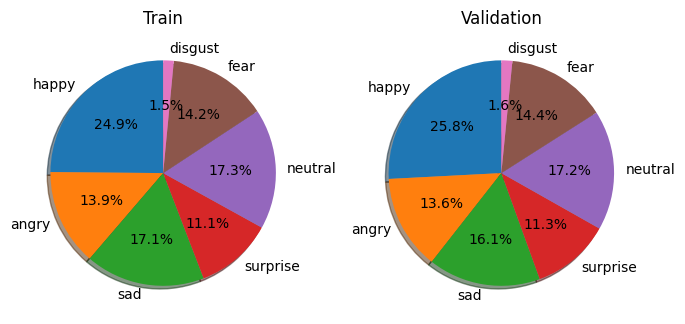

Emotion : happy
	Training : 7164
	 Testing : 1825
Emotion : angry
	Training : 3993
	 Testing : 960
Emotion : sad
	Training : 4938
	 Testing : 1139
Emotion : surprise
	Training : 3205
	 Testing : 797
Emotion : neutral
	Training : 4982
	 Testing : 1216
Emotion : fear
	Training : 4103
	 Testing : 1018
Emotion : disgust
	Training : 436
	 Testing : 111


In [7]:
x_train = np.array([ len(os.listdir(train_dir+i+'/')) for i in emotions ])
x_val = np.array([ len(os.listdir(val_dir+i+'/')) for i in emotions ])
label = emotions
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_val, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Validation')
plt.show()

for i in emotions:
    print('Emotion : ' + i )
    print('\tTraining : ' + str(len(os.listdir(train_dir+i+'/'))) +'\n\t Testing : ' + str(len(os.listdir(val_dir+i+'/'))))

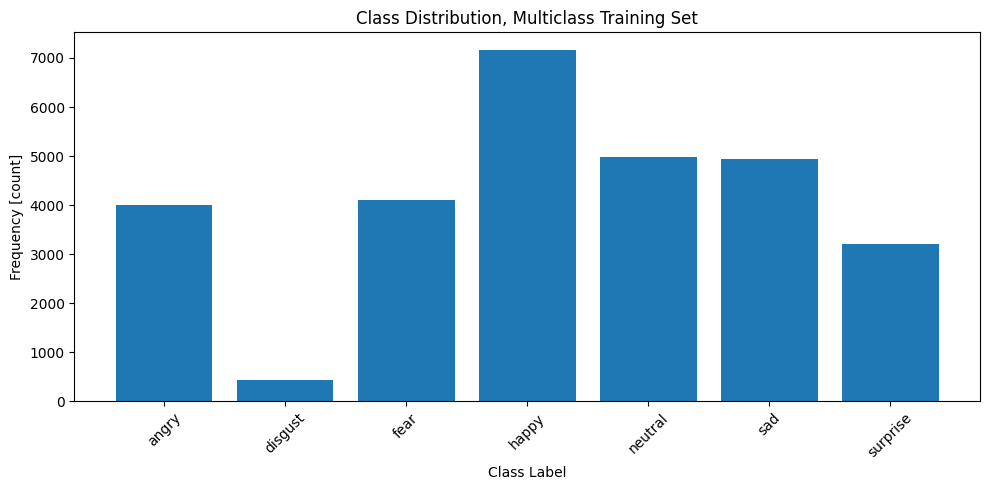

In [8]:
# Create a bar plot of class distributions
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the data
ax.bar(class_distributions.index, class_distributions.values)
ax.set_xlabel("Class Label")
ax.set_ylabel("Frequency [count]")
ax.set_title("Class Distribution, Multiclass Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Define path for hog image
happy_image_path = os.path.join(train_dir, "happy", "97.jpg")

# Define path for antelope image
neutral_image_path = os.path.join(train_dir, "neutral", "92.jpg")

print("happy_image_path type:", type(happy_image_path))
print(happy_image_path)
print()
print("neutral_image_path type:", type(neutral_image_path))
print(neutral_image_path)

happy_image_path type: <class 'str'>
C:/Users/DOCTOR PC/Documents/AI/emotion/images/train/happy\97.jpg

neutral_image_path type: <class 'str'>
C:/Users/DOCTOR PC/Documents/AI/emotion/images/train/neutral\92.jpg


happy_image_pil type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


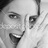

In [10]:
happy_image_pil = Image.open(happy_image_path)

print("happy_image_pil type:", type(happy_image_pil))
happy_image_pil

neutral_image_pil type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


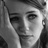

In [11]:
neutral_image_pil = Image.open(neutral_image_path)

print("neutral_image_pil type:", type(neutral_image_pil))
neutral_image_pil

In [12]:
happy_tensor = transforms.ToTensor()(happy_image_pil)

print("happy_tensor type:", type(happy_tensor))
print("happy_tensor shape:", happy_tensor.shape)
print("happy_tensor dtype:", happy_tensor.dtype)
print("happy_tensor device:", happy_tensor.device)

happy_tensor type: <class 'torch.Tensor'>
happy_tensor shape: torch.Size([1, 48, 48])
happy_tensor dtype: torch.float32
happy_tensor device: cpu


In [13]:
neutral_tensor = transforms.ToTensor()(neutral_image_pil)

print("neutral_tensor type:", type(neutral_tensor))
print("neutral_tensor shape:", neutral_tensor.shape)
print("neutral_tensor dtype:", neutral_tensor.dtype)
print("neutral_tensor device:", neutral_tensor.device)

neutral_tensor type: <class 'torch.Tensor'>
neutral_tensor shape: torch.Size([1, 48, 48])
neutral_tensor dtype: torch.float32
neutral_tensor device: cpu


In [38]:
transform = transforms.Compose(
[
transforms.ToTensor(),
transforms.Grayscale(num_output_channels=1)
]
)

print(type(transform))
print(transform)

<class 'torchvision.transforms.transforms.Compose'>
Compose(
    ToTensor()
    Grayscale(num_output_channels=1)
)


In [39]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 28821
    Root location: C:/Users/DOCTOR PC/Documents/AI/emotion/images/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Grayscale(num_output_channels=1)
           )


In [40]:
dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [41]:
print(dataset[0][0].shape)

torch.Size([1, 48, 48])


In [43]:
im = dataset.imgs
print(im[0])

distinct_classes = {x[1] for x in im}
print(distinct_classes)

('C:/Users/DOCTOR PC/Documents/AI/emotion/images/train/angry\\0.jpg', 0)
{0, 1, 2, 3, 4, 5, 6}


In [44]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

In [45]:
print(f"Length of training set: {len(train_dataset)}")
print(f"Length of training set: {len(val_dataset)}")

Length of training set: 23057
Length of training set: 5764


In [46]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [21]:
#Takes a lot of time to run so run when time is sufficient

# train_counts = class_counts(train_dataset)
# train_counts

In [22]:
# will run only when we run the previous one

# train_counts.sort_values().plot(kind="bar");

In [23]:
#will run but takes a lot of time 

# val_counts = class_counts(val_dataset)
# val_counts.sort_values().plot(kind="bar");

In [47]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [48]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# This gives you [batch_size, channels, height, width] for images
image_shape = images.shape
print("Shape of batch of images", image_shape)

# This gives you [batch_size] for labels
label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 1, 48, 48])
Shape of batch of labels: torch.Size([32])


In [49]:
labels

tensor([3, 4, 0, 0, 3, 6, 0, 6, 4, 4, 3, 6, 3, 6, 4, 3, 5, 6, 5, 3, 2, 0, 5, 5,
        2, 6, 4, 4, 0, 3, 4, 6])

## Buliding a Neural Network

In [50]:
flatten = nn.Flatten()
tensor_flatten = flatten(images)

# Print the shape of the flattened tensor

In [51]:
# Image size from our transformer
height = 48
width = 48

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
)

print("model type:", type(model))
print("model structure:")
print(model)

model type: <class 'torch.nn.modules.container.Sequential'>
model structure:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
)


In [52]:
output_layer = nn.Linear(128, 7)
model.append(output_layer)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=7, bias=True)
)


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
model.to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=7, bias=True)
)


In [55]:
summary(model, input_size=(batch_size, 1, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 7]                   --
├─Flatten: 1-1                           [32, 2304]                --
├─Linear: 1-2                            [32, 512]                 1,180,160
├─ReLU: 1-3                              [32, 512]                 --
├─Linear: 1-4                            [32, 128]                 65,664
├─ReLU: 1-5                              [32, 128]                 --
├─Linear: 1-6                            [32, 7]                   903
Total params: 1,246,727
Trainable params: 1,246,727
Non-trainable params: 0
Total mult-adds (M): 39.90
Input size (MB): 0.29
Forward/backward pass size (MB): 0.17
Params size (MB): 4.99
Estimated Total Size (MB): 5.45

In [56]:
loss_fn = nn.CrossEntropyLoss()

In [57]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    # We'll report the loss function's average value at the end of the epoch.
    training_loss = 0.0

    # The train method simply sets the model in training mode. No training
    # has happened.
    model.train()

    # We iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        # Sets the gradients to zero. We need to do this every time.
        optimizer.zero_grad()

        # Unpack images (X) and labels (y) from the batch and add those
        # tensors to the specified device.
        inputs = inputs.to(device)
        targets = targets.to(device)

        # We make a forward pass through the network and obtain the logits.
        # With the logits, we can calculate our loss.
        output = model(inputs)
        loss = loss_fn(output, targets)

        # After calculating our loss, we calculate the numerical value of
        # the derivative of our loss function with respect to all the
        # trainable model weights. Once we have the gradients calculated,
        # we let the optimizer take a "step", in other words, update or
        # adjust the model weights.
        loss.backward()
        optimizer.step()

        # We increment the training loss for the current batch
        training_loss += loss.data.item() * inputs.size(0)

    # We calculate the training loss over the completed epoch
    return training_loss / len(data_loader.dataset)

In [59]:
loss_value = train_epoch(model, optimizer, loss_fn, train_loader, device)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/721 [00:00<?, ?it/s]

The average loss during the training epoch was 1.77.


In [60]:
print(model)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=7, bias=True)
)


In [61]:
def predict(model, data_loader, device="cpu"):
    # This tensor will store all of the predictions.
    all_probs = torch.tensor([]).to(device)

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():

        # Again, we iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # The model produces the logits.  This softmax function turns the
            # logits into probabilities.  These probabilities are concatenated
            # into the `all_probs` tensor.
            probs = F.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs

In [62]:
probabilities_train = predict(model, train_loader, device)
print(probabilities_train.shape)

Predicting:   0%|          | 0/721 [00:00<?, ?it/s]

torch.Size([23057, 7])


In [63]:
len(train_loader.dataset)

23057

# Predictions

In [64]:
probabilities_val = predict(model, val_loader, device)
print(probabilities_val.shape)

Predicting:   0%|          | 0/181 [00:00<?, ?it/s]

torch.Size([5764, 7])


In [65]:
print(probabilities_train[0])

tensor([0.0892, 0.0043, 0.2023, 0.0361, 0.1079, 0.1012, 0.4590])


In [66]:
probabilities_train[0].sum()

tensor(1.)

In [67]:
predictions_train = torch.argmax(probabilities_train, dim=1)

print(f"Predictions shape: {predictions_train.shape}")
print(f"First 10 predictions: {predictions_train[:10]}")

Predictions shape: torch.Size([23057])
First 10 predictions: tensor([6, 3, 2, 3, 3, 2, 3, 4, 3, 6])


In [68]:
predictions_val =  torch.argmax(probabilities_val, dim=1)


print(f"Predictions shape: {predictions_val.shape}")
print(f"First 10 predictions: {predictions_val[:10]}")

Predictions shape: torch.Size([5764])
First 10 predictions: tensor([3, 6, 6, 2, 2, 4, 3, 3, 6, 3])


In [69]:
# accuracy on tesst

targets_train = torch.cat([labels for _, labels in train_loader]).to(device)
is_correct_train = torch.eq(predictions_train, targets_train)
total_correct_train = torch.sum(is_correct_train).item()
accuracy_train = total_correct_train / len(train_loader.dataset)

print(f"Accuracy on the training data: {accuracy_train}")

Accuracy on the training data: 0.18194040855271718


In [70]:
# accuracy on val

targets_val = torch.cat([labels for _, labels in val_loader]).to(device)
is_correct_val =  torch.eq(predictions_val, targets_val)
total_correct_val = torch.sum(is_correct_val).item()
accuracy_val =  total_correct_val / len(val_loader.dataset)


print(f"Accuracy on the validation data: {accuracy_val}")

Accuracy on the validation data: 0.30725190839694655


In [71]:
def score(model, data_loader, loss_fn, device="cpu"):
    # Initialize the total loss (cross entropy) and the number of correct
    # predictions. We'll increment these values as we loop through the
    # data.
    total_loss = 0
    total_correct = 0

    # We set the model to evaluation mode. This mode is the opposite of
    # train mode we set in the train_epoch function.
    model.eval()

    # Since we're not training, we don't need any gradient calculations.
    # This tells PyTorch not to calculate any gradients, which speeds up
    # some calculations.
    with torch.no_grad():
        # We iterate over the batches in the data loader and feed
        # them into the model for the forward pass.
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            # Calculating the loss function for this batch
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            # Calculating the correct predictions for this batch
            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )

In [72]:
loss_train, accuracy_train = score(model, train_loader, loss_fn, device)
print(f"Training accuracy from score function: {accuracy_train}")

Scoring:   0%|          | 0/721 [00:00<?, ?it/s]

Training accuracy from score function: 0.31305026673027714


In [73]:
loss_val, accuracy_val =  score(model, val_loader, loss_fn, device)
print(f"Validation accuracy from score function: {accuracy_val}")

Scoring:   0%|          | 0/181 [00:00<?, ?it/s]

Validation accuracy from score function: 0.30725190839694655


In [74]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):

    for epoch in range(1, epochs + 1):
        # Run train_epoch once, and capture the training loss.
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Score the model on the validation data.
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}"
        )

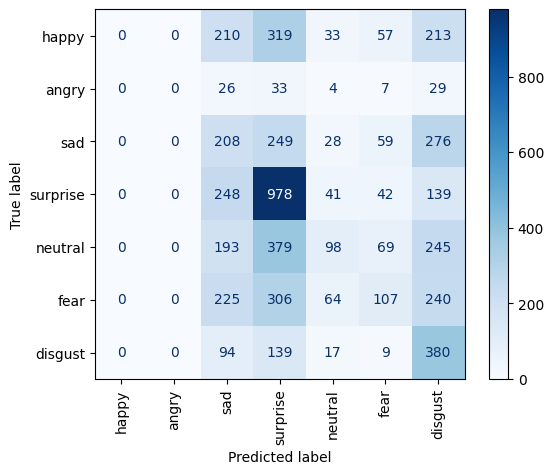

In [75]:
cm = confusion_matrix(targets_val.cpu(), predictions_val.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['happy', 'angry', 'sad', 'surprise', 'neutral', 'fear', 'disgust'])

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

In [76]:
img = Image.open(os.path.join(folder_path, "train/happy/97.jpg"))
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)

model.eval()
prediction = F.softmax(model(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction])

tensor(0)


In [ ]:
torch.save(model.state_dict(), os.path.join("model", "shallownet"))
new_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
)
model_state_dict = torch.load(os.path.join("model", "shallownet"))
new_model.load_state_dict(model_state_dict)

In [79]:
sample_confidence = torch.tensor([0.13, 0.01, 0.02, 0.12, 0.10, 0.34])